In [1]:
import pymc3 as pm
import numpy as np
import dolfin as dl; dl.set_log_level(40)
from forward_solve import Fin, get_space
from dl_model import load_parametric_model_avg
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from theano.compile.ops import as_op
import theano.tensor as tt
from gaussian_field import make_cov_chol
import theano
import matplotlib.pyplot as plt
%matplotlib inline

## Setup true solution

A randomly generated (using the Matern 3/2 kernel) conductivity field is used as the true solution.

In [2]:
resolution = 40
V = get_space(resolution)
chol = make_cov_chol(V)
solver = Fin(V)

# Synthetic true solution
z_true = dl.Function(V)
norm = np.random.randn(len(chol))
nodal_vals = np.exp(0.5 * chol.T @ norm)
z_true.vector()[:] = nodal_vals[:]
w, y, A, B, C = solver.forward(z_true)
true_qoi = solver.qoi_operator(w)

# Observations
obs_noise_sigma = 0.01
obs_data = true_qoi + obs_noise_sigma * np.random.randn(len(true_qoi))
model = load_parametric_model_avg('relu', Adam, 0.0024, 5, 50, 130, 400, V.dim())
phi = np.loadtxt('data/basis_five_param.txt',delimiter=",")
z = dl.Function(V)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Keras model weights loaded


In [3]:
@as_op(itypes=[tt.dvector], otypes=[tt.dvector])
def fwd_model(nodal_vals):
    #  nodal_vals = np.exp(0.5 * chol.T @ norm)
    z.vector()[:] = nodal_vals[:]
    
    # Full-order model forward QoI
    x, y, A, B, C = solver.forward(z)
    qoi = solver.qoi_operator(x)
    
    # Reduced forward QoI
    #A_r, B_r, C_r, x_r, y_r = solver.averaged_forward(z, phi)
    #qoi_r = solver.reduced_qoi_operator(x_r)
    
    # Deep learning correction for QoI
    #qoi_e_NN = model.predict(np.array([nodal_vals]))
    #qoi = qoi_r + qoi_e_NN
    return qoi.reshape((5,))

In [4]:
Wdofs_x = V.tabulate_dof_coordinates().reshape((-1, 2))
V0_dofs = V.dofmap().dofs()
points = Wdofs_x[V0_dofs, :] 

In [5]:
with pm.Model() as misfit_model:

    # Prior 
    ls = 0.3
    cov = pm.gp.cov.Matern52(2, ls=ls)
    mean = pm.gp.mean.Constant(0.5)
    nodal_vals = pm.gp.Latent(mean_func=mean, cov_func=cov).prior('nodal_vals', X=points)

    noise_var = 1e-4
    noise_cov = noise_var * np.eye(obs_data.size)

    avg_temp = pm.Deterministic('avg_temp', fwd_model(nodal_vals))
    #avg_temp = fwd_model(nodal_vals)

    likelihood = pm.MvNormal('likelihood', mu=avg_temp, cov=noise_cov, observed=obs_data)

    step_method = pm.step_methods.metropolis.Metropolis()
    trace = pm.sample(100,step=step_method, cores=1)

Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
Metropolis: [nodal_vals_rotated_]
100%|██████████| 600/600 [00:41<00:00, 14.37it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x181cb0860>,
      dtype=object)

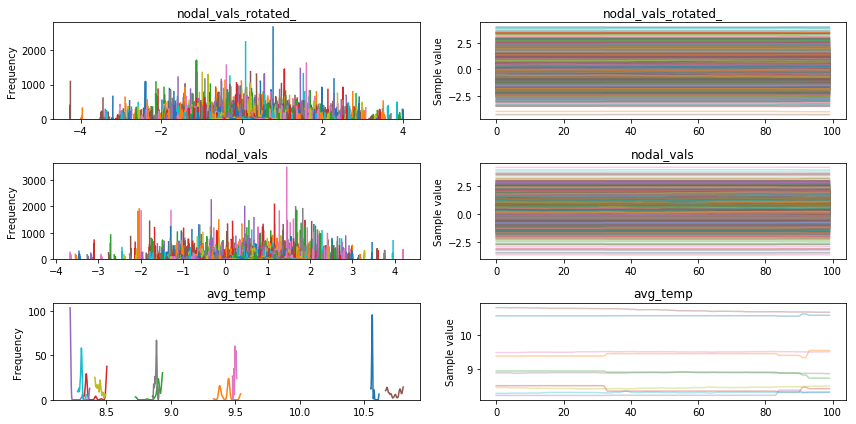

In [6]:
pm.traceplot(trace)

In [7]:
post_mean = np.mean(trace['nodal_vals'],0)

In [8]:
z_mean = dl.Function(V)
z_mean.vector()[:] = post_mean
abs_err = dl.Function(V)
abs_err.vector()[:] = np.abs(post_mean - z_true.vector()[:])

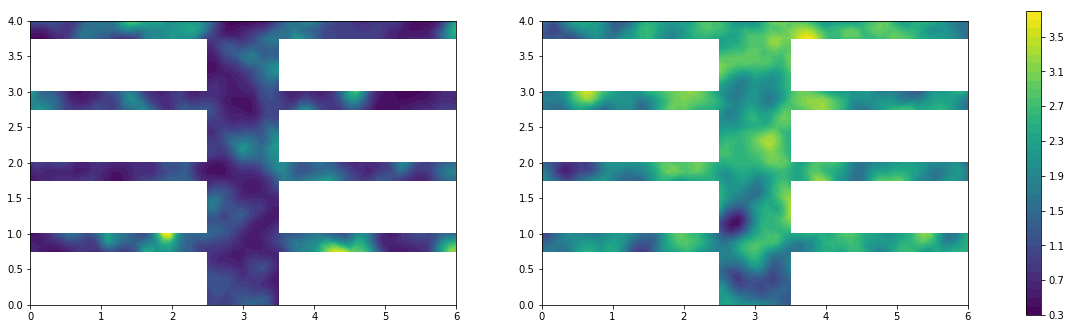

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21,14))
plt.sca(ax1)
p_true = dl.plot(z_true)
plt.sca(ax2)
p_mean = dl.plot(z_mean)
fig.colorbar(p_true, ax=[ax1, ax2], shrink=0.4)
plt.show()

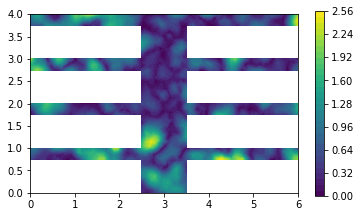

In [10]:
p_err = dl.plot(abs_err)
plt.colorbar(p_err, shrink=0.85)
plt.show()

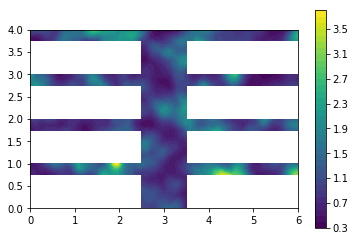

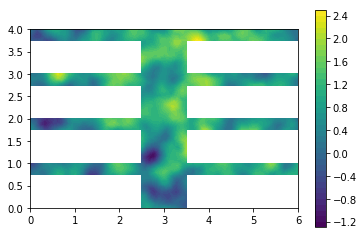

In [11]:
p_true = dl.plot(z_true)
plt.colorbar(p_true)
plt.show()
p_mean = dl.plot(z_mean)
plt.colorbar(p_mean)
plt.show()